# Class 12: The Linear Probability Model and Logistic Regression

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt  
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
import theano
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist

from PIL import Image
import urllib.request as url
import io
from IPython.display import Image

Using TensorFlow backend.


## Classification

* Very frequently, we have **categorical labels** in our data, together with features.  
* We will build up the concept of a two-class categorical label based on material we have already discussed.  
    * We will motivate the idea through the use of a **latent** label (or variable).
    * Like time series, we do not observe the underlying DGP.
    * Rather we observe whether or not something **occurred** based on the **realization of a latent index**.  
    * The observation is $\{0, 1\}$ or $\{$not observed, observed$\}$.
* This area of statistical learning is called **classification**.
    * We seek to train a predictor function, $pred$, for a label using $K$ features, $x$.
    * $y_i = pred(x_{i1}, ..., x_{iK})$.
* The **realization** of this predictor, given a feature set, is sometimes called **"yhat"** or $\hat{y}$.
* It is easy to visualize conceptually the nature of this class of questions with scatterplots. 

In [2]:
# Generate some data for scatterplots.

random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
arr = np.concatenate((red, blue), axis=0)

Text(0.5, 1.0, 'A Scatterplot')

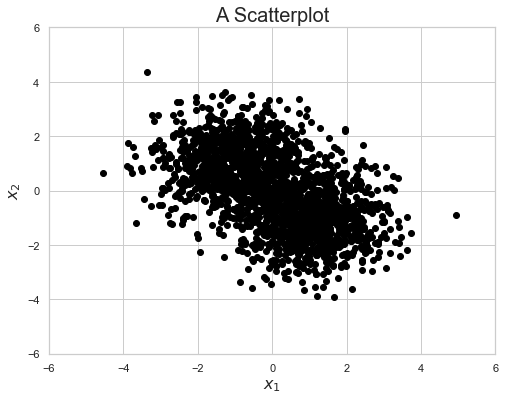

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(arr[0:999, 1], arr[0:999, 0], c="black")
plt.scatter(arr[1000:1999, 1],arr[1000:1999, 0], c="black")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot', fontsize = 20)

#### Notes
1. This scatterplot should be quite familiar by now.  
2. We have two features, $(x_1, x_2)$, and some label, which could be **anything**.
    * A row in our dataframe (or Excel spreadsheet) could be [house price, age, size].
3. Now imagine that the dots are **two flavors**, {red, blue}.
    * That is, a row in the dataframe contains three columns, a label and two features.
    * [flavor, $x_1$, $x_2$].  
    * For example, [red, -2, 2].

Text(0.5, 1.0, 'A Scatterplot with Red-Blue Labels')

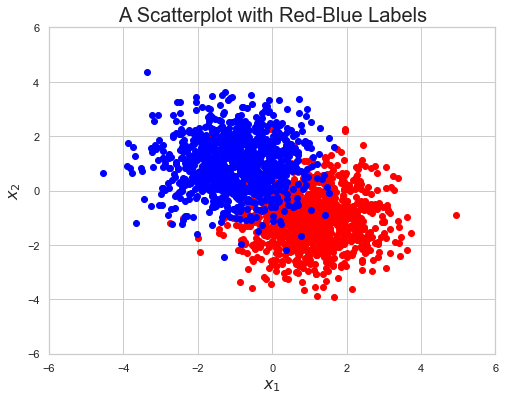

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(arr[0:999, 1], arr[0:999, 0], c="red")
plt.scatter(arr[1000:1999, 1],arr[1000:1999, 0], c="blue")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Red-Blue Labels', fontsize = 20)

#### How We Will Proceed
1. Start with an algorithm we have been using for the entire semester.
2. Turn to a very popular algorithm used for classification of labels with two classes.
    * 1 and 2 combined constitute a very large share of the algorithms used in applied data science.
3. Examine algorithms to predict multi-class labels. 

## Classification: The Linear Probability Model and The Logistic Classifier (or "Logit")

* The use case in multiple regression was to examine how house prices in Staten Island varied with characteristics (or features) of the houses themselves.  
    * This use case involved a continuous label, house prices.  
    * That is, $y$ was quantitative: the sales prices of single-family houses in Staten Island.  
    * Frequently, in data science, we face categorical labels, as above.  
* In economics, we call this the analysis of "limited dependent variables." 
* In computer science, it is classification.  
    * This different terminology refers to the **same thing**.  
* Because this classifier is the ground upon which data scientists of all stripes converge, it is an important methodological technique that I want you to understand **thoroughly**.

### Latent Labels (or Variables)

* One can think of categorical variable as being driven by an underlying DGP.
    * As with time series, we do not observe the continuous process.
    * We observe realizations.
* Consider the now familiar DGP: $y_i^*=x_i^\prime\beta+\epsilon_i$
* $y_i^*$ is a latent value for person *i* that is **unobserved by us**.  
    * For example, you do not observe the value I place on this canister of water.  
    * You simply observe me drinking it.  
    * In other words, you observe the outcome my choice set $\{$drink, not drink$\}$.  
    * Another example would be observing someone taking a taxi.  
    * You do not observe the value that someone places on the taxi ride.  You know that she has many alternative methods of transportation, all with varying values to her, but you observe the outcome of her choice.
* $x_i$ are a vector of features (or attributes or predictors or independent variables).  We observe these.
* $\beta$ is a vector that measures how features affect the latent index, which we will estimate statistically. 
* $\epsilon_i$ retains its status as our ignorance.  

**What do we observe?**

${\displaystyle d_i = }$
$\left\{ \begin{array}{l l} 
{1} & \quad \text{if person i takes a cab, which happens when } y_i^*\ge0\\ 
{0} & \quad \text{if person i does not take a cab, which happens when } y_i^*\lt0 \\
\end{array} \right.$  

## The Logistic Classifier

Again, we start with a sample of size, $N$.  We are going to change the linear model to the following:

$Pr(d_i=1)=x_i^\prime\beta+\epsilon_i$

We will then impose a distributional assumption on $\epsilon_i$, namely that it is logistically distributed.

${\displaystyle Pr(d_i=1) = \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}}$ 

We see immediately that this is NOT **a linear model** (that is, a model that is linear in $\beta$).

${\displaystyle Pr(d_i=0) = 1 - Pr(d_i=1) = 1 - \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)} = \frac{1}{1+\exp(x_i^\prime\beta)}}$

An **odds ratio**:

${\displaystyle \frac{Pr(d_i=1)}{Pr(d_i=0)} = \frac{Pr(d_i=1)}{1 - Pr(d_i=1)} = \exp(x_i^\prime\beta)}$

This implies that the log-odds ratio (or "logit") is:

${\displaystyle \log\big(\frac{Pr(d_i=1)}{1 - Pr(d_i=1)}\big) = x_i^\prime\beta}$, which is linear in $\beta$.

To address the estimation of the parameters of interest, we need to construct a likelihood function that we will tell the computer to optimize.  Start by constructing the likelihood for observation $i$:

${\displaystyle l_i = Pr(d_i=1)^{d_i}\cdot Pr(d_i=0)^{(1-d_i)}=\frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

If we make some assumptions we can write:

${\displaystyle L = \prod_{i=1}^N l_i = \prod_{i=1}^N \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

Goal is to tell the machine to maximize $L$ with respect to $\beta$ given the data we have. 

Once we have done that, we can make probabilistic predictions (or classifications).

### The Confusion Matrix

* With a logit predictor, you can correctly predict a 1 or correctly predict 0.
* Obviously, you can incorrectly predict a 1 or incorrectly predict a 0.
* This is the basis of the confusion matrix, together with other measures of accuracy.

In [5]:
print("What is a confusion matrix, and what might we do with its elements?")
print("")
print()
table = [[" ","0", "1"],["0", "TN", "FP"],["1", "FN", "TP"]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

print("Zeros are negatives, and ones are positives")
print("Correctly predicting a 0 is a True Negative")
print("Correctly predicting a 1 is a True Positive")
print("Incorrectly predicting a 0 is a False Negative")
print("Incorrectly predicting a 1 is a Fale Positive")
print("")
print("The True Positive Rate is TP / (TP + FN)") 
print("The False Positive Rate is FP / (TN + FP)")
print("The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)")
print("The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction")

What is a confusion matrix, and what might we do with its elements?


╒═══╤════╤════╕
│   │ 0  │ 1  │
├───┼────┼────┤
│ 0 │ TN │ FP │
├───┼────┼────┤
│ 1 │ FN │ TP │
╘═══╧════╧════╛

Zeros are negatives, and ones are positives
Correctly predicting a 0 is a True Negative
Correctly predicting a 1 is a True Positive
Incorrectly predicting a 0 is a False Negative
Incorrectly predicting a 1 is a Fale Positive

The True Positive Rate is TP / (TP + FN)
The False Positive Rate is FP / (TN + FP)
The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)
The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction


### The Mean Squared Error and Bias/Variance Decomposition

For any predictor, $\hat{y}$, of label, $y$, with a dataframe of size $N$, the MSE ${\displaystyle =\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y_i})^2}$.

In words, the MSE is the average of the **squared deviations** between our prediction and the truth.  We have already seen this measure.  Without the $\frac{1}{N}$, it is the Sum of Squared Residuals function, $SSR(\beta)$, that we minimized with the linear regression model.  We simply normalize it by the dataframe size (which does not alter the optimal values of $\beta$).  

In practice, we do not much care about the overall MSE, but the MSE associated with the test set, in which case we simply limit the calculation to the test set.  

It can be shown with some basic algebra that the MSE can be **decomposed**.  Namely,

$MSE \propto Var(\hat y) + Bias(\hat y)$

What do the **variance** and **bias** of a learning algorithm measure? 

**Variance** refers to the amount by which $\hat y$ would change if we train the algorithm using a different training set.  Since the training data are used to train the algorithm, a different training set would result in a different $\hat y$.  Ideally $\hat y$ should not considerably vary between training sets because an algorithm that has high variance implies that small changes in training sets can result in large changes in $\hat{y}$.  

**Generally, more flexible statistical methods have higher variance.**  That is, they are sensitive to their training sets.

**Bias** refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a simple representation.  For example, linear regression assumes that there is a linear relationship between between the label and the features, $\hat y = x'\hat \beta$.  It is unlikely that any real-life use case truly has such a simple linear relationship, and so performing linear regression will undoubtedly result in some bias in the estimate of $\hat{y}$.  

**Generally, more flexible statistical methods result in less bias.**  That is, including higher order terms (squares, cubics, or interactions) increases the predictive power (lower bias), but decreases our ability easily to interpret the results.

This is called the **bias-variance tradeoff**.

**It is inherent in any machine learning algorithm**.  

## An Introduction to Neural Networks and Deep Learning:
### The Logit as the Precusor to Deep Learning

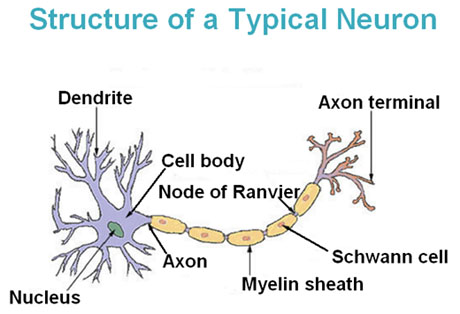

In [6]:
url = "https://upload.wikimedia.org/wikipedia/commons/b/bd/Neuron.jpg"
Image(url, width=400, height=400)

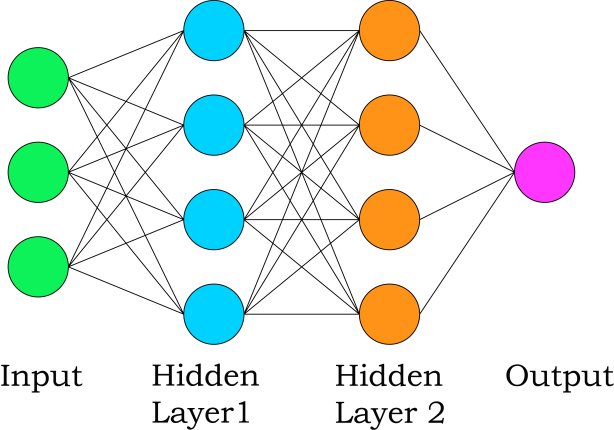

In [7]:
url = "https://en.mlab.ai/sites/default/files/inline-images/neural1_1.jpg"
Image(url, width=400, height=400)

### Overview
Because of their remarkable success in digital image processing, among other areas of data science, the origin of neural networks, the precusor to deep learning, is claimed by many disciplines and by many people.

The "electronic brain" and the neuroscience of the 1950's.
Computer science: Character recongition and the U.S. Postal Service.
Economics and finance: Let's make a million dollars!
Like many approaches in data science, the technique has waxed and waned through the ages, seemingly rediscovered each time.

Let's not focus on the past (despite my personal interest on the origin of algorithms). Let's focus on the present. Fortunately, we've already seen a simple example of a neural network: the logit classifier.

The logit classifier is a simple neural network: feed-forward MLP with one hidden layer.
A neural network builds on this simple concept by introducing many "logits" and tying them together with weights.
We estimated the $\beta$'s of the logits via maximum likelihood.
We tie them with weights that we also esimate via maximum likelihood.

### Computer science

Character recongition, the U.S. Postal Service, and Yann LeCun's famous MNIST data.
A Cambrian-like explosion since 2008.

### Economics and finance
See, among others, papers by Ron Gallant (UNC Chapel Hill), Timothy Savage (NYU), George Tauchen (Duke), and Hal White (UCSD).

## A Motivating Example: A Logic Gate

In [8]:
np.random.seed(1907)
f1 = np.random.randint(0, 2, 10000)
f2 = np.random.randint(0, 2, 10000)
label = np.logical_xor(f1, f2) * 1
data = pd.DataFrame({'label':label, 'f1':f1, 'f2':f2})
data.head(10)

,label,f1,f2
0,0,1,1
1,1,1,0
2,0,1,1
3,0,0,0
4,0,1,1
5,1,1,0
6,0,1,1
7,0,0,0
8,0,0,0
9,1,1,0


### Notes
* A simple data structure that is difficult to analyze using our algorithms to date.
* The train/test split is a different method to evaluate the performance of an algorithm.
    * Randomly split the whole dataset into two parts.
    * Fit the algorithm on the training dataset.
    * Evaluate the performance of the algorithm on the test dataset using the MSE criterion.

In [9]:
datatrain, datatest = train_test_split(data, test_size = 0.2, random_state = 6281993)

In [10]:
# The linear probability model.
# Generate predictions for the test data based on the results of the algorithm fit on the training data.

mod = smf.ols(formula='label ~ f1 + f2', data = datatrain).fit()
print(mod.summary())
datatest['lm_hat'] = mod.predict(exog = datatest)

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9553
Date:                Sat, 23 Nov 2019   Prob (F-statistic):              0.385
Time:                        11:26:16   Log-Likelihood:                -5804.6
No. Observations:                8000   AIC:                         1.162e+04
Df Residuals:                    7997   BIC:                         1.164e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5084      0.010     52.211      0.0

In [11]:
print(datatest['label'].describe())
print("")
print(datatest['lm_hat'].describe())

count    2000.000000
mean        0.499500
std         0.500125
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

count    2000.000000
mean        0.506672
std         0.007677
min         0.495926
25%         0.504838
50%         0.508433
75%         0.517345
max         0.517345
Name: lm_hat, dtype: float64


In [12]:
print((1 - 0.5)**2)
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['lm_hat']))

0.25
The MSE is 0.250072


### Notes
* Using classical hypothesis testing, we would fail to reject the null that the impact of f1 and f2 is zero.
* In the test data, the labels are 0 or 1, with an average value of 0.5.
* For the predicted labels, the average value is about 0.5 with no variability.
* The MSE is $(1 - 0.5)^2$

In [13]:
# The linear probability model.
# Generate predictions for the test data based on the results of the algorithm fit on the training data.

mod = smf.logit(formula='label ~ f1 + f2', data = datatrain).fit()
print(mod.summary())
datatest['logit_hat'] = mod.predict(exog = datatest)

Optimization terminated successfully.
         Current function value: 0.692937
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Sat, 23 Nov 2019   Pseudo R-squ.:               0.0001723
Time:                        11:26:16   Log-Likelihood:                -5543.5
converged:                       True   LL-Null:                       -5544.4
Covariance Type:            nonrobust   LLR p-value:                    0.3846
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0337      0.039      0.866      0.386      -0.043       0.110
f1            -0.0500      0.

In [14]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['logit_hat']))

The MSE is 0.250073


In [15]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat
2803      1   0   1  0.517345   0.517343
5397      1   0   1  0.517345   0.517343
1739      0   1   1  0.504838   0.504839
5103      1   0   1  0.517345   0.517343
3750      0   0   0  0.508433   0.508434
1654      1   1   0  0.495926   0.495924
3057      1   1   0  0.495926   0.495924
8124      0   0   0  0.508433   0.508434
6477      0   0   0  0.508433   0.508434
6597      1   1   0  0.495926   0.495924
8399      1   1   0  0.495926   0.495924
494       0   1   1  0.504838   0.504839
4775      1   1   0  0.495926   0.495924
3787      0   0   0  0.508433   0.508434
7204      0   0   0  0.508433   0.508434
1951      1   0   1  0.517345   0.517343
2198      1   1   0  0.495926   0.495924
4699      0   0   0  0.508433   0.508434
2602      1   0   1  0.517345   0.517343
6044      1   1   0  0.495926   0.495924


### Notes 
* Note that both algortithms perform poorly.
* Easy to impliment, but they cannot "fit" the logit gate.
* Hence, the development of neural networks, the precusor to deep learning.

In [16]:
X_train = datatrain[['f1', 'f2']].values
y_train = datatrain['label'].values
X_test = datatest[['f1', 'f2']].values
y_test = datatest['label'].values
dim = X_train.shape[1]

In [17]:
# This the simplest neural network, the multilayer perceptron with on hidden layer.

np.random.seed(1066)

model = keras.Sequential([
    keras.layers.Dense(1, activation='relu', input_dim=dim),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 - 2s - loss: 0.9507 - accuracy: 0.4950 - val_loss: 0.9171 - val_accuracy: 0.4985
Epoch 2/10
8000/8000 - 0s - loss: 0.9092 - accuracy: 0.4954 - val_loss: 0.8795 - val_accuracy: 0.4985
Epoch 3/10
8000/8000 - 0s - loss: 0.8726 - accuracy: 0.4954 - val_loss: 0.8468 - val_accuracy: 0.4985
Epoch 4/10
8000/8000 - 0s - loss: 0.8406 - accuracy: 0.4954 - val_loss: 0.8180 - val_accuracy: 0.4985
Epoch 5/10
8000/8000 - 0s - loss: 0.8127 - accuracy: 0.4954 - val_loss: 0.7929 - val_accuracy: 0.4985
Epoch 6/10
8000/8000 - 0s - loss: 0.7885 - accuracy: 0.4954 - val_loss: 0.7712 - val_accuracy: 0.4985
Epoch 7/10
8000/8000 - 0s - loss: 0.7673 - accuracy: 0.4954 - val_loss: 0.7526 - val_accuracy: 0.4985
Epoch 8/10
8000/8000 - 0s - loss: 0.7489 - accuracy: 0.4954 - val_loss: 0.7362 - val_accuracy: 0.4985
Epoch 9/10
8000/8000 - 0s - loss: 0.7329 - accuracy: 0.4954 - val_loss: 0.7218 - val_accuracy: 0.4985
Epoch 10/10
8000/8000 - 0s - loss:

In [18]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.258227


In [19]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat    dl_hat
2803      1   0   1  0.517345   0.517343  0.347817
5397      1   0   1  0.517345   0.517343  0.347817
1739      0   1   1  0.504838   0.504839  0.308591
5103      1   0   1  0.517345   0.517343  0.347817
3750      0   0   0  0.508433   0.508434  0.574312
1654      1   1   0  0.495926   0.495924  0.574312
3057      1   1   0  0.495926   0.495924  0.574312
8124      0   0   0  0.508433   0.508434  0.574312
6477      0   0   0  0.508433   0.508434  0.574312
6597      1   1   0  0.495926   0.495924  0.574312
8399      1   1   0  0.495926   0.495924  0.574312
494       0   1   1  0.504838   0.504839  0.308591
4775      1   1   0  0.495926   0.495924  0.574312
3787      0   0   0  0.508433   0.508434  0.574312
7204      0   0   0  0.508433   0.508434  0.574312
1951      1   0   1  0.517345   0.517343  0.347817
2198      1   1   0  0.495926   0.495924  0.574312
4699      0   0   0  0.508433   0.508434  0.574312
2602      1   0   1  0.517345  

### Notes
* The hidden layer improves the performance of the model.
* Let's continue to add hidden perceptron, as well as additional layers.

In [20]:
np.random.seed(1066)

model = keras.Sequential([
    keras.layers.Dense(5, activation='relu', input_dim=dim),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 - 1s - loss: 0.7225 - accuracy: 0.7461 - val_loss: 0.7111 - val_accuracy: 0.7495
Epoch 2/10
8000/8000 - 0s - loss: 0.6957 - accuracy: 0.7525 - val_loss: 0.6857 - val_accuracy: 0.7495
Epoch 3/10
8000/8000 - 0s - loss: 0.6726 - accuracy: 0.7525 - val_loss: 0.6656 - val_accuracy: 0.7495
Epoch 4/10
8000/8000 - 0s - loss: 0.6566 - accuracy: 0.7525 - val_loss: 0.6514 - val_accuracy: 0.7495
Epoch 5/10
8000/8000 - 0s - loss: 0.6432 - accuracy: 0.7525 - val_loss: 0.6382 - val_accuracy: 0.7495
Epoch 6/10
8000/8000 - 0s - loss: 0.6304 - accuracy: 0.7525 - val_loss: 0.6255 - val_accuracy: 0.7495
Epoch 7/10
8000/8000 - 0s - loss: 0.6178 - accuracy: 0.7525 - val_loss: 0.6125 - val_accuracy: 0.7495
Epoch 8/10
8000/8000 - 0s - loss: 0.6049 - accuracy: 0.7525 - val_loss: 0.5994 - val_accuracy: 0.7495
Epoch 9/10
8000/8000 - 0s - loss: 0.5917 - accuracy: 0.7525 - val_loss: 0.5860 - val_accuracy: 0.7495
Epoch 10/10
8000/8000 - 0s - loss:

In [21]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.190310


In [22]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat    dl_hat
2803      1   0   1  0.517345   0.517343  0.629283
5397      1   0   1  0.517345   0.517343  0.629283
1739      0   1   1  0.504838   0.504839  0.497298
5103      1   0   1  0.517345   0.517343  0.629283
3750      0   0   0  0.508433   0.508434  0.437177
1654      1   1   0  0.495926   0.495924  0.569250
3057      1   1   0  0.495926   0.495924  0.569250
8124      0   0   0  0.508433   0.508434  0.437177
6477      0   0   0  0.508433   0.508434  0.437177
6597      1   1   0  0.495926   0.495924  0.569250
8399      1   1   0  0.495926   0.495924  0.569250
494       0   1   1  0.504838   0.504839  0.497298
4775      1   1   0  0.495926   0.495924  0.569250
3787      0   0   0  0.508433   0.508434  0.437177
7204      0   0   0  0.508433   0.508434  0.437177
1951      1   0   1  0.517345   0.517343  0.629283
2198      1   1   0  0.495926   0.495924  0.569250
4699      0   0   0  0.508433   0.508434  0.437177
2602      1   0   1  0.517345  

In [23]:
np.random.seed(1066)

model = keras.Sequential([
    keras.layers.Dense(5, activation='relu', input_dim=dim),
    keras.layers.Dense(25, activation='relu', input_dim=dim),
    keras.layers.Dense(25, activation='relu', input_dim=dim),
    keras.layers.Dense(25, activation='relu', input_dim=dim),    
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 - 2s - loss: 0.6591 - accuracy: 0.8981 - val_loss: 0.6183 - val_accuracy: 1.0000
Epoch 2/10
8000/8000 - 0s - loss: 0.5530 - accuracy: 1.0000 - val_loss: 0.4733 - val_accuracy: 1.0000
Epoch 3/10
8000/8000 - 0s - loss: 0.3825 - accuracy: 1.0000 - val_loss: 0.2931 - val_accuracy: 1.0000
Epoch 4/10
8000/8000 - 0s - loss: 0.2163 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 1.0000
Epoch 5/10
8000/8000 - 0s - loss: 0.1029 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 1.0000
Epoch 6/10
8000/8000 - 0s - loss: 0.0415 - accuracy: 1.0000 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 7/10
8000/8000 - 0s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 8/10
8000/8000 - 0s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 9/10
8000/8000 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 10/10
8000/8000 - 0s - loss:

In [24]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.000016


In [25]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat    dl_hat
2803      1   0   1  0.517345   0.517343  0.999951
5397      1   0   1  0.517345   0.517343  0.999951
1739      0   1   1  0.504838   0.504839  0.001397
5103      1   0   1  0.517345   0.517343  0.999951
3750      0   0   0  0.508433   0.508434  0.005783
1654      1   1   0  0.495926   0.495924  0.994806
3057      1   1   0  0.495926   0.495924  0.994806
8124      0   0   0  0.508433   0.508434  0.005783
6477      0   0   0  0.508433   0.508434  0.005783
6597      1   1   0  0.495926   0.495924  0.994806
8399      1   1   0  0.495926   0.495924  0.994806
494       0   1   1  0.504838   0.504839  0.001397
4775      1   1   0  0.495926   0.495924  0.994806
3787      0   0   0  0.508433   0.508434  0.005783
7204      0   0   0  0.508433   0.508434  0.005783
1951      1   0   1  0.517345   0.517343  0.999951
2198      1   1   0  0.495926   0.495924  0.994806
4699      0   0   0  0.508433   0.508434  0.005783
2602      1   0   1  0.517345  

### Notes
* The MLP improves the performance of the algorithm considerably.
* Can be implemented with little computational burden.

## Images as Data
* Images can be digitized and therefore analyzed.
* Deep learning algorithms were developed for this purpose.
* Let's use an example with clothing.

In [26]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

A shoe


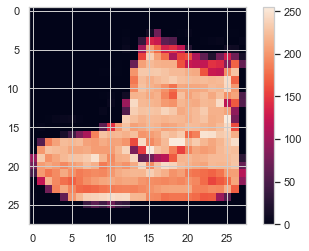

In [27]:
print('A shoe')

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(True)
plt.show()

In [28]:
# Think of this as a spreadsheet.

train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [29]:
# Normalize data.

train_images = train_images / 255.0
test_images = test_images / 255.0

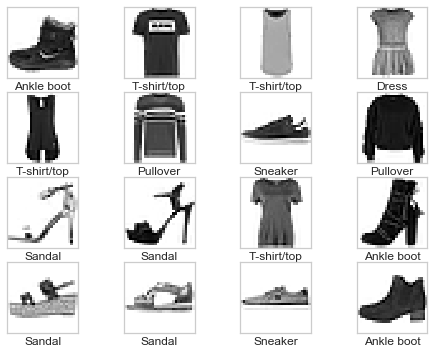

In [30]:
plt.figure(figsize=(8, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [31]:
# 6000 of each type of clothing

print(np.unique(class_names, return_counts=True))
print(np.unique(train_labels, return_counts=True))

(array(['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal',
       'Shirt', 'Sneaker', 'T-shirt/top', 'Trouser'], dtype='<U11'), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


In [32]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], verbose=2)
model.fit(train_images, train_labels, epochs=10)
predictions = model.predict(test_images)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 229us/sample - loss: 0.4814 - accuracy: 0.8269
Epoch 2/10
60000/60000 [==============================] - 13s 213us/sample - loss: 0.3624 - accuracy: 0.8678
Epoch 3/10
60000/60000 [==============================] - 14s 231us/sample - loss: 0.3280 - accuracy: 0.8787
Epoch 4/10
60000/60000 [==============================] - 13s 215us/sample - loss: 0.3063 - accuracy: 0.8864
Epoch 5/10
60000/60000 [==============================] - 13s 214us/sample - loss: 0.2891 - accuracy: 0.8920
Epoch 6/10
60000/60000 [==============================] - 13s 214us/sample - loss: 0.2724 - accuracy: 0.8981
Epoch 7/10
60000/60000 [==============================] - 13s 216us/sample - loss: 0.2632 - accuracy: 0.8999
Epoch 8/10
60000/60000 [==============================] - 14s 227us/sample - loss: 0.2513 - accuracy: 0.9055
Epoch 9/10
60000/60000 [==============================] - 13s 219us/sample - loss: 0.2427 - accuracy: 0.9

In [33]:
predictions.argmax(axis=1)
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [34]:
# Standard measures of performance.
# First, the accuracy rate on the test or validation set.
# Second, the multiclass confusion matrix.
# Third, precision by class.

from sklearn.metrics import accuracy_score
print('Accuracy Rate: %f' % accuracy_score(test_labels, predictions.argmax(axis=1)))

Accuracy Rate: 0.888400


In [35]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix:\n%s' % confusion_matrix(test_labels, predictions.argmax(axis=1)))

Confusion matrix:
[[867   2  13  17   3   1  94   0   3   0]
 [  2 969   0  20   3   0   5   0   1   0]
 [ 25   0 809   8  76   0  82   0   0   0]
 [ 24   6  19 887  35   0  26   0   3   0]
 [  2   1 101  31 785   0  77   0   3   0]
 [  0   0   0   1   0 966   0  18   0  15]
 [140   1  72  26  49   0 709   0   3   0]
 [  0   0   0   0   0  16   0 968   0  16]
 [  5   0   4   2   4   2   7   3 973   0]
 [  0   0   0   1   0   5   1  42   0 951]]


In [36]:
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(test_labels, predictions.argmax(axis=1)))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.81      0.80      1000
           3       0.89      0.89      0.89      1000
           4       0.82      0.79      0.80      1000
           5       0.98      0.97      0.97      1000
           6       0.71      0.71      0.71      1000
           7       0.94      0.97      0.95      1000
           8       0.99      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [37]:
# Identify errors.

(test_labels - predictions.argmax(axis = 1) > 0).nonzero()

(array([  12,   17,   23,   25,   40,   51,   68,   89,   98,  107,  127,
         147,  150,  151,  153,  239,  241,  244,  247,  316,  320,  325,
         344,  378,  382,  404,  409,  441,  444,  460,  526,  529,  548,
         562,  563,  572,  581,  586,  595,  634,  635,  639,  664,  669,
         688,  689,  697,  702,  711,  725,  732,  753,  761,  779,  801,
         805,  887,  905,  909,  920,  921,  960,  966,  971,  977,  979,
         994, 1131, 1152, 1160, 1162, 1210, 1235, 1294, 1300, 1329, 1336,
        1343, 1455, 1458, 1462, 1469, 1471, 1496, 1522, 1587, 1596, 1620,
        1632, 1643, 1645, 1650, 1671, 1744, 1771, 1792, 1814, 1822, 1841,
        1846, 1855, 1917, 1922, 1943, 1954, 1980, 2006, 2016, 2021, 2067,
        2073, 2100, 2144, 2162, 2191, 2195, 2245, 2247, 2290, 2311, 2312,
        2316, 2318, 2320, 2373, 2397, 2417, 2421, 2425, 2431, 2447, 2451,
        2464, 2469, 2476, 2491, 2509, 2527, 2540, 2551, 2559, 2573, 2580,
        2629, 2670, 2671, 2685, 2688, 

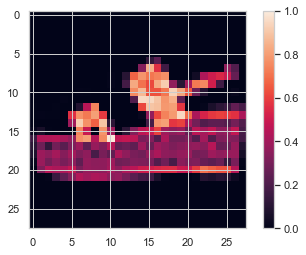

True label is 7
The algorithm classifies it as a 5 with probability 0.995692


In [38]:
img = 12
plt.figure()
plt.imshow(train_images[img])
plt.colorbar()
plt.grid(True)
plt.show()
print('True label is %d' % test_labels[img])
print('The algorithm classifies it as a %d with probability %f' % (predictions[img].argmax(), max(predictions[img])))

### Notes
* Deep learning consists of many different type of algorithms.
* As one can see from the above, the algorithm can make bad predictions with high probability. 

In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label: 
        color = 'blue'
    else: 
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(predictions_array), 
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

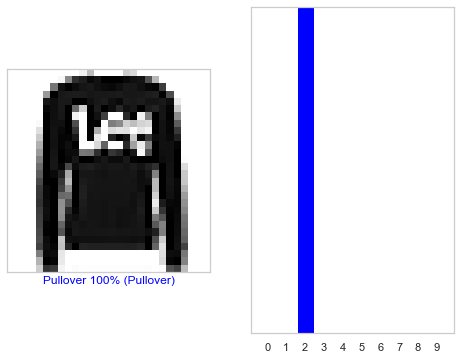

In [40]:
i = 1
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

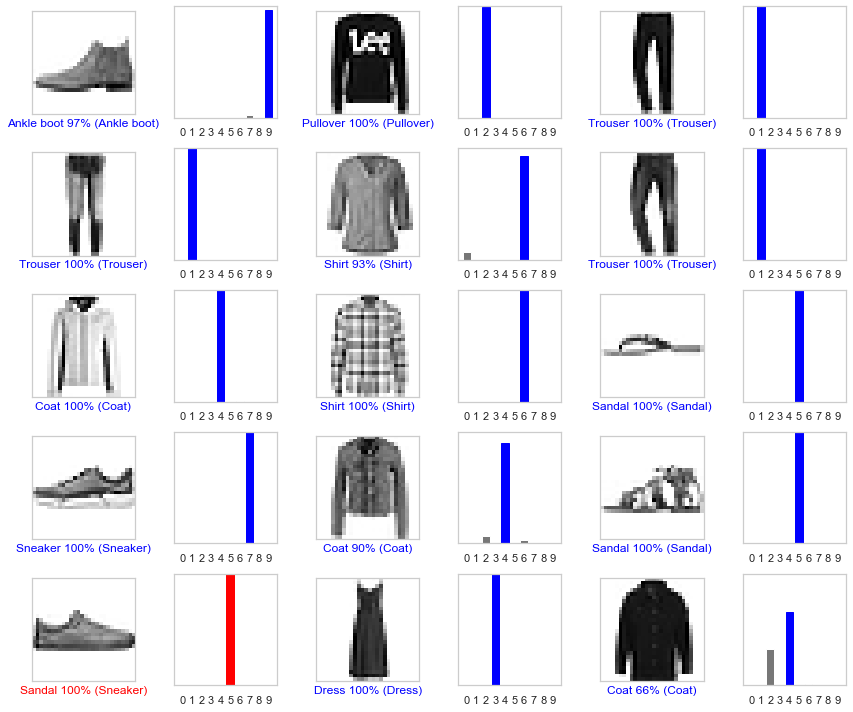

In [41]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()